In [36]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import wave
import torch
import pandas as pd
from jupyterplot import ProgressPlot
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
from Audio_Sentiment_Analysis.audio_classifier.audio_classifier import AudioClassifier
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
AUDIO_CLASSIFIER_MODEL = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/audio_classifier/audio_classifier_model.pkl"

torch.set_num_threads(1)
plt.rcParams['figure.dpi'] = 300

# Loading File and its Framing from IEMOCAP

Sample Rate: 16000 Hz


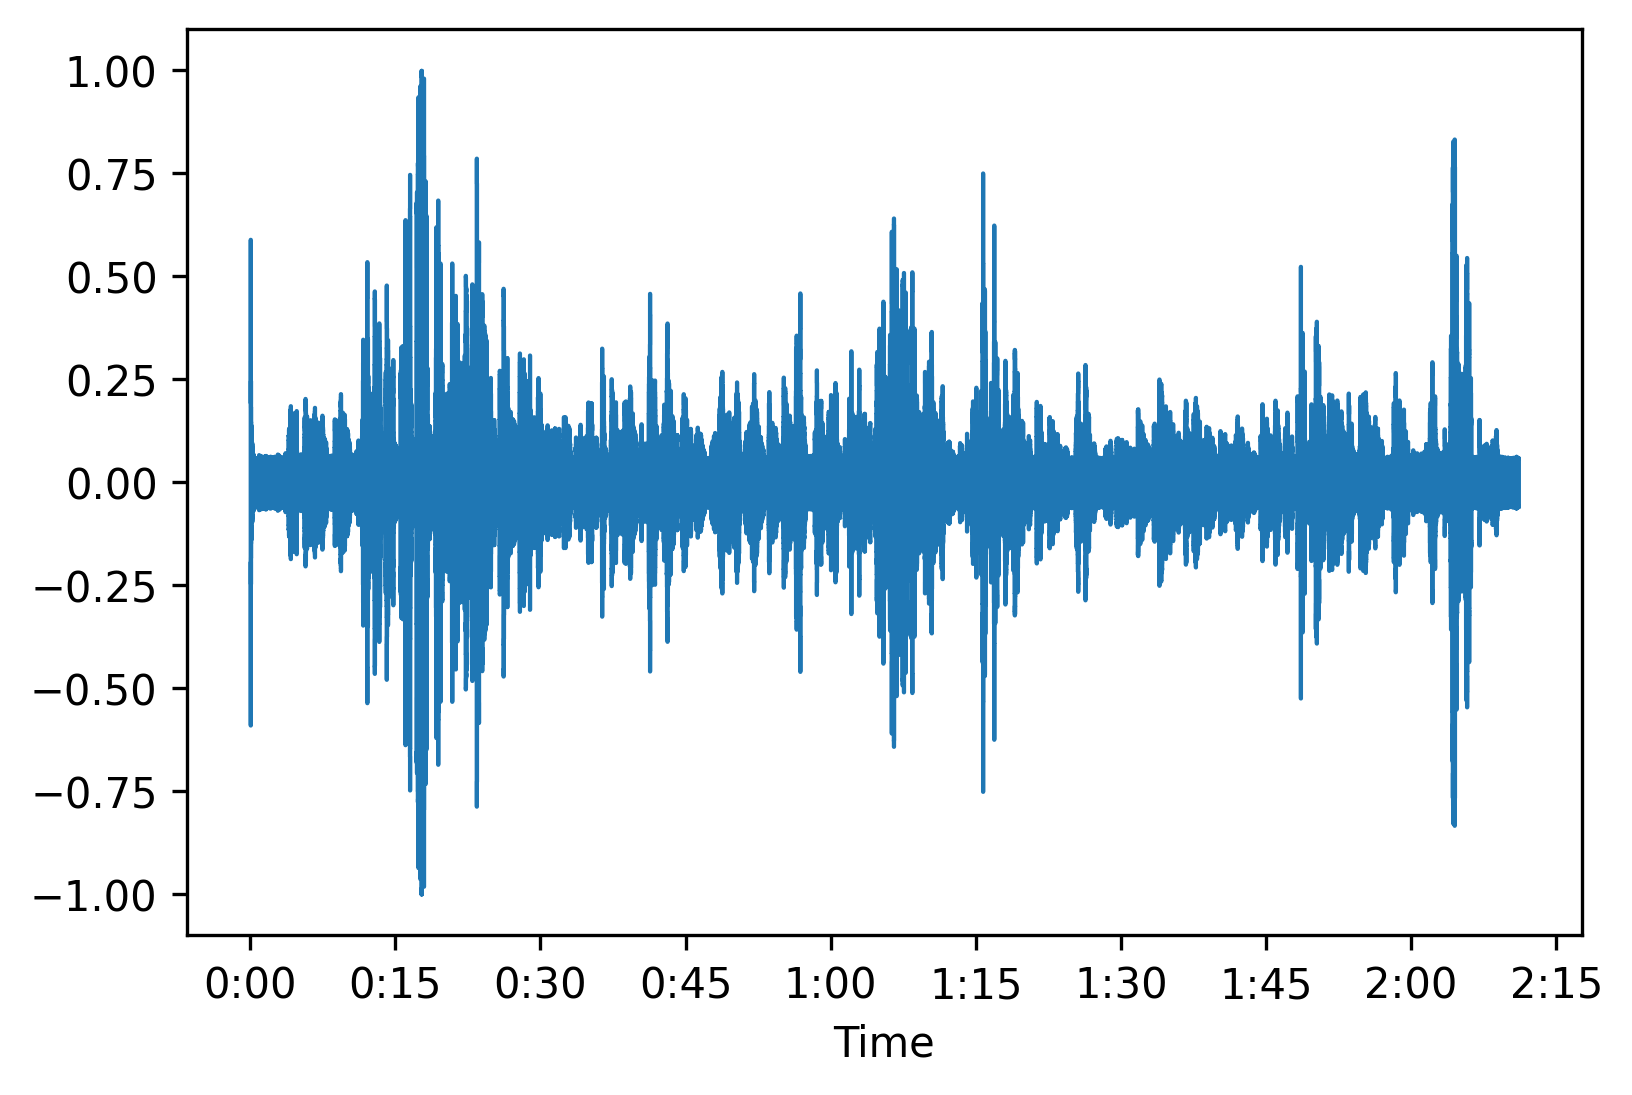

In [37]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01F_impro03.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y, sr=sr)
print(f"Sample Rate: {sr} Hz")
plt.show()

In [38]:
def read_wav_part_from_local(path: str, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        fs = wavread.getframerate()
        start = int(start_s * fs)
        duration = int(duration_s * fs)
        wavread.setpos(start)
        wav_bytes = wavread.readframes(duration)
        
        if wavread.getsampwidth() == 2:
            dtype = 'int16'
        elif wavread.getsampwidth() == 4:
            dtype = 'int32'
        else:
            raise NotImplemented('Error Reading Sample')

        wav_array = np.frombuffer(wav_bytes, dtype=dtype)
        return wav_array, fs


def int2float32(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/abs_max
    sound = sound.squeeze()
    return sound


vad_model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)

classifier_model = AudioClassifier(AUDIO_CLASSIFIER_MODEL)

STEP = 0.03
MIN_CONFIDENCE = 0.7
MIN_SEGMENT_DURATION = 1
MAX_SEGMENT_DURATION = 5

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


# Classifying Segments

In [39]:
pp = ProgressPlot(plot_names=["Real-Time Voiced Segments Predictions"], line_names=["predicted labels"], x_label="segments")

segments = []

current_audio_array = None
segments_classifications = []
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), STEP):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, STEP)
    if len(wav_array) == 960:
        wav_array = int2float32(wav_array)
        confidence = vad_model(torch.from_numpy(wav_array), fs).item()


        end = start+STEP

        if confidence >= MIN_CONFIDENCE:
            if prev_end == None:
                current_audio_array = wav_array
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= MIN_SEGMENT_DURATION:
                current_audio_array = np.append(current_audio_array, wav_array)
                prev_end = end
                if prev_end - prev_start >= MAX_SEGMENT_DURATION:
                    prediction = classifier_model.predict_segment(current_audio_array, True)
                    segments_classifications.append(prediction)
                    pp.update(float(prediction))
                    segments.append((prev_start, prev_end))
                    prev_start, prev_end = None, None
                    current_audio_array = None
            else:
                if prev_end - prev_start >= MIN_SEGMENT_DURATION:
                    prediction = classifier_model.predict_segment(current_audio_array, True)
                    segments_classifications.append(prediction)
                    pp.update(float(prediction))
                    segments.append((prev_start, prev_end))
                current_audio_array = wav_array
                prev_start, prev_end = start, end

if (len(segments) and segments[-1] != (prev_start, prev_end)) or ((not len(segments)) and prev_end):
    if prev_end - prev_start > MIN_SEGMENT_DURATION:
        prediction = classifier_model.predict_segment(current_audio_array, True)
        segments_classifications.append(prediction)
        pp.update(float(prediction))
        segments.append((prev_start, prev_end))

<IPython.core.display.Javascript object>

In [40]:
id_labels = {0: "anger", 1: "happiness", 2: "sadness", 3: "neutral"}

print(f"Number of classified segments: {len(segments_classifications)}")
segments_classifications_labels = pd.DataFrame([id_labels[x] for x in segments_classifications])
print(segments_classifications_labels)
segments_classifications_labels.describe()

Number of classified segments: 26
            0
0     neutral
1   happiness
2   happiness
3   happiness
4   happiness
5   happiness
6   happiness
7   happiness
8   happiness
9   happiness
10  happiness
11  happiness
12  happiness
13  happiness
14  happiness
15  happiness
16  happiness
17  happiness
18  happiness
19  happiness
20  happiness
21  happiness
22  happiness
23    neutral
24    neutral
25    neutral


,0
count,26
unique,2
top,happiness
freq,22


In [41]:
pd.DataFrame([y - x for x,y in segments]).describe()

,0
count,26.000000
mean,4.594615
std,1.178223
min,1.530000
25%,5.010000
50%,5.010000
75%,5.122500
max,5.670000


In [45]:
segments_labeled = []
segments_labeled_times = []
with open(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/Ses01F_impro03.txt') as emotions_test_file:
    for line in emotions_test_file:
        if line[0] == '[':
            args = line.split()
            segments_labeled.append(args[4] if args[4] != 'exc' else 'hap')
            segments_labeled_times.append((float(args[0][1:]), float(args[2][:-1])))


In [46]:
print(f"Number of classified segments: {len(segments_labeled)}")
segments_labeled = pd.DataFrame(segments_labeled)
print(segments_labeled)
segments_labeled.describe()

Number of classified segments: 52
      0
0   hap
1   hap
2   hap
3   xxx
4   hap
5   hap
6   hap
7   xxx
8   hap
9   hap
10  hap
11  xxx
12  hap
13  hap
14  xxx
15  hap
16  hap
17  neu
18  neu
19  neu
20  xxx
21  hap
22  neu
23  neu
24  hap
25  hap
26  hap
27  neu
28  neu
29  sur
30  hap
31  xxx
32  xxx
33  neu
34  hap
35  neu
36  neu
37  xxx
38  neu
39  xxx
40  hap
41  hap
42  hap
43  neu
44  sur
45  sur
46  neu
47  neu
48  neu
49  hap
50  hap
51  neu


,0
count,52
unique,4
top,hap
freq,24


In [44]:
pd.DataFrame([y - x for x,y in segments_labeled_times]).describe()

,0
count,52.000000
mean,3.156206
std,1.318708
min,0.842500
25%,2.210000
50%,2.808750
75%,3.941875
max,6.340000
